In [3]:
import pySim_lib as pysim
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import subprocess


plt.rcParams.update({"text.usetex": True})

def emu_reader(fn):
    emu_array = np.load(fn)
    emu_sim = {'pos': emu_array[:3],
                'vel': emu_array[3:]}
    return emu_sim

#create ascii files for all nbody_0000*.bin files
n = 26
for i in range(1,n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    particles_data = emu_reader(f'/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/emu_sims/{filename}.npy')
    #export to .dat file
    positions = particles_data['pos'].T  # Transpose to get the right shape
    velocities = particles_data['vel'].T
    data_to_save = np.hstack((positions, velocities))
    #print(data_to_save.shape)
    np.savetxt(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/emu_sims/{filename}.dat", data_to_save, fmt="%.6f", delimiter = "\t", comments="")

def voidfinder_reader(name):
    voids = np.loadtxt(name)
    radius = voids[:, 0]        
    coords = voids[:, 1:4]     
    return radius, coords
    

In [ ]:
#dictionary to store the void data
void_data_incl_small = {}

input_file_path = "/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/parameterfiles/sparkling_box.param"
for i in range(7,n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    #change the parameters
    updates = { "FileTracers": {1: f"../input/emu_sims/{filename}.dat"}, "FileVoids": {1: f"../output/emu_output/void_{filename}.dat"}}

    with open(input_file_path, "r") as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        columns = line.split() 
        
        if len(columns) > 1:  
            param_name = columns[0] 
            if param_name in updates: 
                for col, new_value in updates[param_name].items():
                    if col < len(columns):  
                        columns[col] = new_value

                lines[i] = "   ".join(columns) + "\n"  

    # Datei mit den neuen Werten überschreiben
    with open(input_file_path, "w") as file:
        file.writelines(lines)

    #run the void finder
    path_to_sparkling = "/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/src_box"
    input_file = "../parameterfiles/sparkling_box.param" 
    result = subprocess.run(["./main.x", input_file], cwd=path_to_sparkling, capture_output=True, text=True)

In [ ]:
#delete small voids
a = 268
#do all files have same number of particles? YES!
N_particles = len(data_to_save)
V_box = a**3
n_m = N_particles / V_box
r_min = (V_box / N_particles)**(1/3) * 2.5

void_data_incl_small = {}
void_data_dict = {}

num_files = min(len(void_data_incl_small), n)  # Ensures we don't exceed available data

for i in range(1, n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    void_key = f"void_data_incl_small_{filename}"

    void_data_incl_small[void_key] = voidfinder_reader(f'/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/output/emu_output/void_{filename}.dat')
    
    radii_incl_small, coords_incl_small = void_data_incl_small[void_key]

    allowed = radii_incl_small > r_min  

    radii = radii_incl_small[allowed]
    coords_voids = coords_incl_small[allowed]

    void_data = np.column_stack((radii, coords_voids))
    void_data_dict[f"void_data_{filename}"] = void_data
    print(f"Number of all voids for {filename}:", len((radii_incl_small)))
    print(f"Number of filtered voids for {filename}:", len(void_data))

Number of all voids for L400-N128_set1_emu_run0601: 10127
Number of filtered voids for L400-N128_set1_emu_run0601: 2442
Number of all voids for L400-N128_set1_emu_run0602: 10231
Number of filtered voids for L400-N128_set1_emu_run0602: 2338
Number of all voids for L400-N128_set1_emu_run0603: 10202
Number of filtered voids for L400-N128_set1_emu_run0603: 2435
Number of all voids for L400-N128_set1_emu_run0604: 10143
Number of filtered voids for L400-N128_set1_emu_run0604: 2395


/var/folders/ss/qz81s18561g4v9nxv6k7wq_w0000gn/T/ipykernel_95954/2674451670.py:19: UserWarning:

You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



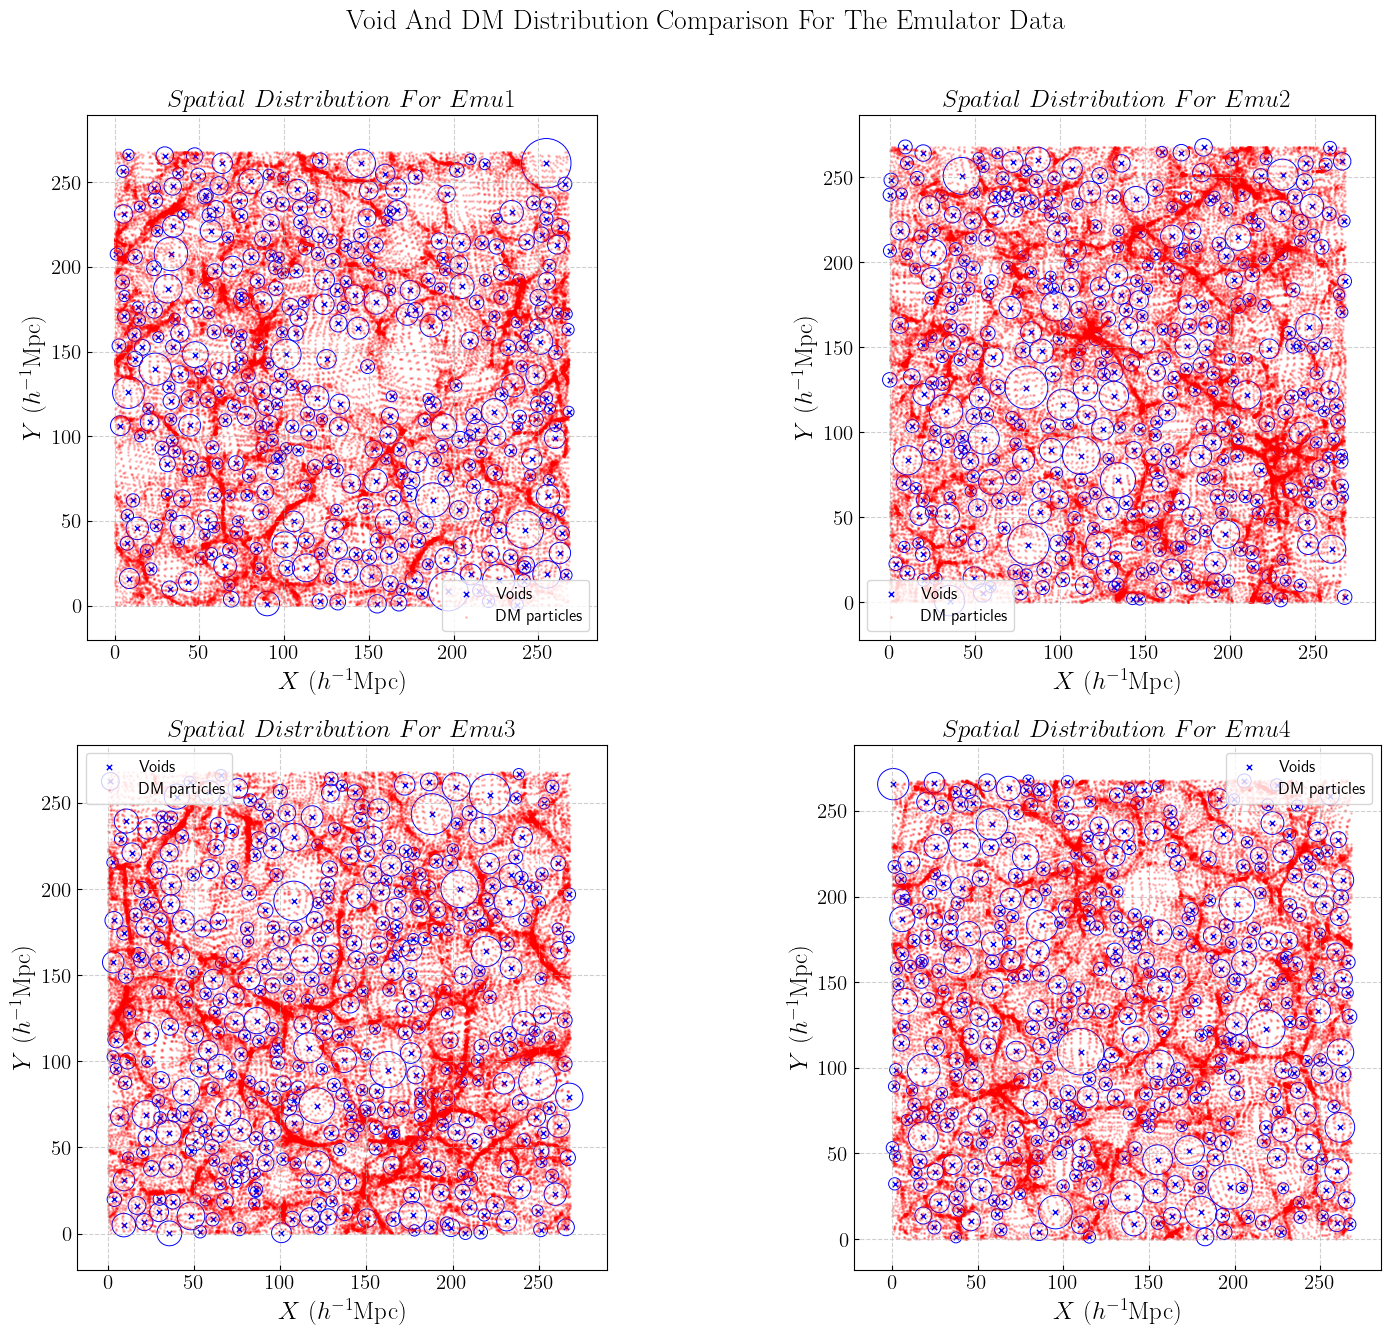

In [ ]:
import matplotlib.patches as patches
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), dpi=100)
fig.suptitle("$ \mathrm{Void \ And \ DM \ Distribution \ Comparison \ For \ The \ Emulator \ Data} $", fontsize=20, y=0.95)

axes = axes.flatten()
z_min = 0
z_max = 10
for i, ax in enumerate(axes[:5-1], start=1):
    filename = f"L400-N128_set1_emu_run06{i:02}"

    void_key = f"void_data_incl_small_{filename}"
    radii_incl_small, coords_incl_small = void_data_incl_small[void_key]

    data_particles = np.loadtxt(f'/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/emu_sims/{filename}.dat')
    positions = data_particles[:, 0:3]
    velocities = data_particles[:, 3:6]

    mask = (coords_incl_small[:, 2] >= z_min) & (coords_incl_small[:, 2] <= z_max)
    ax.scatter(coords_incl_small[mask, 0], coords_incl_small[mask, 1], s=15, c='blue', label='Voids', edgecolors='blue', linewidths=1, marker='x')

    for x, y, r in zip(coords_incl_small[mask, 0], coords_incl_small[mask, 1], radii_incl_small[mask]):
        circle = patches.Circle((x, y), r, color='blue', fill=False, linewidth=0.7)
        ax.add_patch(circle)

    # Plot dark matter particles in the (x, y) plane
    mask_dm = (positions[:, 2] >= z_min) & (positions[:, 2] <= z_max)
    ax.scatter(positions[mask_dm, 0], positions[mask_dm, 1], s=1, alpha=0.2, c='red', label='DM particles')


    ax.tick_params(axis='both', which='both', direction='in', labelsize=15)
    ax.set_xlabel("$X$ $(h^{-1}  \mathrm{Mpc})$", fontsize=18)
    ax.set_ylabel("$Y$ $(h^{-1}  \mathrm{Mpc})$", fontsize=18)
    ax.set_title(f"$Spatial \ Distribution \ For \ Emu{i}$", fontsize=18)
    ax.legend(fontsize=12)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)

if len(axes) > 5-1:
    axes[5-1].axis('off')


#plt.tight_layout()
plt.subplots_adjust(wspace=0.0001)

Text(0.5, 1.0, '$Continuous \\ Void \\ Size \\ Function \\ Emulator$')

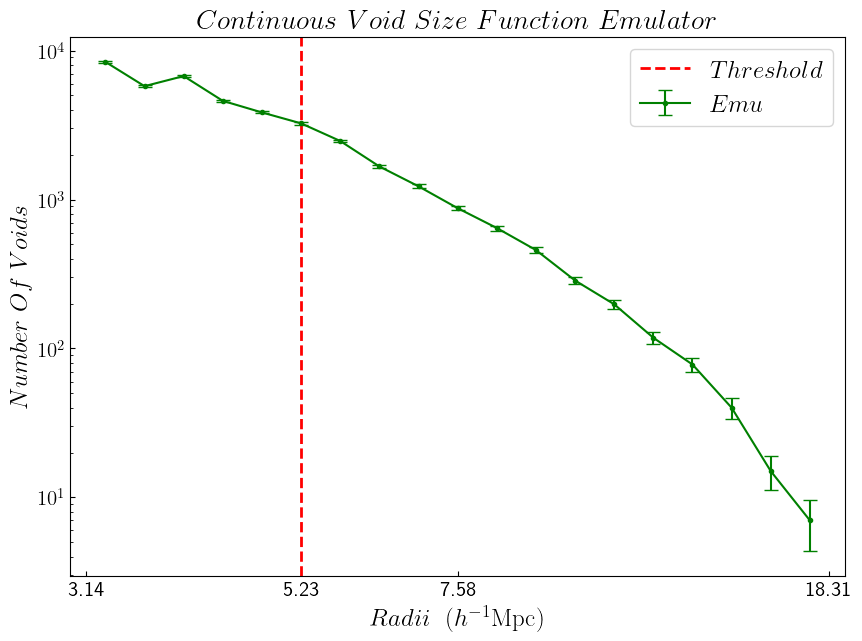

In [ ]:
import itertools

#void size function
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
#collect all void radii
all_nbody_radii_incl_small = []
for i in range(1, n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    void_key = f"void_data_incl_small_{filename}"
    radii_incl_small, _ = void_data_incl_small[void_key]

    if isinstance(radii_incl_small, (list, np.ndarray)):  
        all_nbody_radii_incl_small.append(radii_incl_small)
    else:
        all_nbody_radii_incl_small.append([radii_incl_small]) 
        
all_nbody_radii_incl_small = list(itertools.chain.from_iterable(all_nbody_radii_incl_small))

bins = np.logspace(np.log10(min(all_nbody_radii_incl_small)), np.log10(max(all_nbody_radii_incl_small)), 20)


hist_nbody, bin_edges_nbody= np.histogram(all_nbody_radii_incl_small, bins=bins)
bin_centers = np.sqrt(bin_edges_nbody[:-1] * bin_edges_nbody[1:])
errors_nbody = np.sqrt(hist_nbody/(n-1))
ax.errorbar(bin_centers, hist_nbody/(n-1), yerr=errors_nbody, fmt='o', color='green', linestyle='-', capsize=5, markersize=3, label='$Emu$')

ax.set_xscale('log')
ax.set_yscale('log')

ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)

ticks = np.logspace(np.log10(min(all_nbody_radii_incl_small)), np.log10(max(all_nbody_radii_incl_small)), 3)
ticks = np.append(ticks, r_min)  
ax.set_xticks(ticks)
ax.set_xticks([], minor=True)  # delete Minor-Ticks, falls nötig
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}".rstrip('0').rstrip('.')))  

ax.axvline(x=r_min, color='red', linestyle='--', linewidth=2, label='$Threshold$')
plt.legend(fontsize = 18)

plt.xlabel('$Radii$  \ $(h^{-1} \ \mathrm{Mpc})$', fontsize = 18)
plt.ylabel('$Number \ Of \ Voids$', fontsize = 18)
plt.title('$Continuous \ Void \ Size \ Function \ Emulator$', fontsize = 20)

Text(0.5, 1.0, '$Emulator \\ Velocity \\ Distribution$')

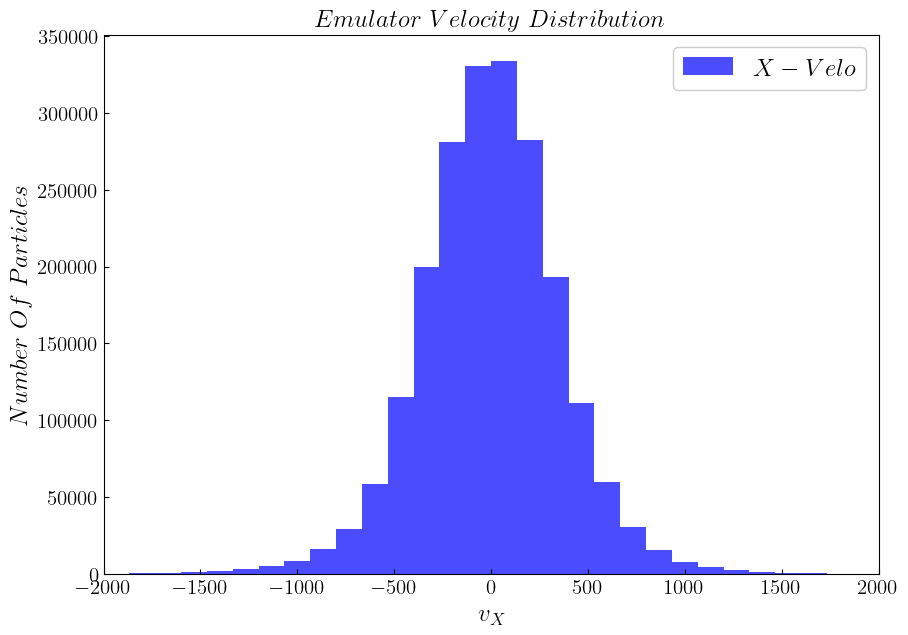

In [ ]:
#plot histogram of particle velocities
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
all_velocities = []
for i in range(1, n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    particles_data = np.loadtxt(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/emu_sims/{filename}.dat")
    x_velo = particles_data[:,3]
    all_velocities.append(x_velo)

x_min, x_max = -2000, 2000
bins = np.linspace(x_min, x_max, 31)
result = ax.hist(x_velo/(n-1), bins=bins, color='blue', alpha=0.7, label='$X-Velo$')
plt.legend(fontsize = 18, framealpha = 1)
plt.xlim(x_min, x_max)

ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
plt.xlabel("$v_X$", fontsize=18)
plt.ylabel("$Number \ Of \ Particles$", fontsize=18)
plt.title("$Emulator \ Velocity \ Distribution$", fontsize=18)

In [ ]:
#integrated density profile
n_m = N_particles/V_box
R_max = np.max(all_nbody_radii_incl_small)
print("R_max=", R_max)
print("R_min=", r_min)
all_delta_profiles_groups = {1: [], 2: [], 3: [], 4: []} 
all_radii_groups = {1: [], 2: [], 3: [], 4: []}

all_voids_sorted = []  #one file for all sorted voids together
sorted_voids_per_file = {} #updated dictionary with seperated but sorted files
#sort voids
for key, value in void_data_dict.items():
    sorted_void_arrays = sorted(value, key=lambda x: x[0])  
    sorted_voids_per_file[key] = np.array(sorted_void_arrays)
    all_voids_sorted.extend(sorted_void_arrays)

all_voids_sorted = np.array(sorted(all_voids_sorted, key=lambda x: x[0]))
all_radii = all_voids_sorted[:, 0]

group_limits = np.percentile(all_radii, [25, 50, 75, 100])
print("Group limits:", group_limits)

# Bins wie im funktionierenden Code
scaled_bins = np.linspace(0, 4, 31)
scaled_bin_centers = (scaled_bins[:-1] + scaled_bins[1:]) / 2

# Ergebnis-Container
all_delta_profiles_groups = {1: [], 2: [], 3: [], 4: []}
all_radii_groups = {1: [], 2: [], 3: [], 4: []}

# Schleife über Files
for i in range(1, n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    key = f"void_data_{filename}"
    voids = sorted_voids_per_file[key]

    delta_profiles_groups = {1: [], 2: [], 3: [], 4: []}
    radii_groups = {1: [], 2: [], 3: [], 4: []}

    particles_data = np.loadtxt(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/emu_sims/{filename}.dat")
    positions = particles_data[:, :3]
    
    tree = cKDTree(positions, boxsize=a + 1e-13)

    for R_v_i, center_i in zip(voids[:, 0], voids[:, 1:4]):
        if R_v_i < r_min:
            continue  # skip small voids, just in case...
        if r_min <= R_v_i < group_limits[0]:
            group = 1
        elif group_limits[0] <= R_v_i < group_limits[1]:
            group = 2
        elif group_limits[1] <= R_v_i < group_limits[2]:
            group = 3
        else:
            group = 4

        # physical bins
        bins = scaled_bin_centers * R_v_i
        density_profile = []

        for r in bins:
            indices = tree.query_ball_point(center_i, r)
            n_particles = len(indices)
            density = n_particles / ((4/3) * np.pi * r**3)
            density_profile.append(density)

        density_profile = np.array(density_profile)
        delta_profile = density_profile / n_m - 1

        delta_profiles_groups[group].append(delta_profile)
        radii_groups[group].append(R_v_i)

    #save each file
    np.save(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/{filename}_integrated_delta_profiles_population_spaced_groups.npy", (delta_profiles_groups, radii_groups))

    #save for all files
    for group in delta_profiles_groups:
        all_delta_profiles_groups[group].extend(delta_profiles_groups[group])
        all_radii_groups[group].extend(radii_groups[group])

np.save("/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/all_integrated_delta_profiles_population_spaced_groups.npy", (all_delta_profiles_groups, all_radii_groups))

R_max= 18.30893
R_min= 5.234375
Group limits: [ 5.62761  6.25165  7.47737 18.30893]


/var/folders/ss/qz81s18561g4v9nxv6k7wq_w0000gn/T/ipykernel_95954/1596566643.py:30: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



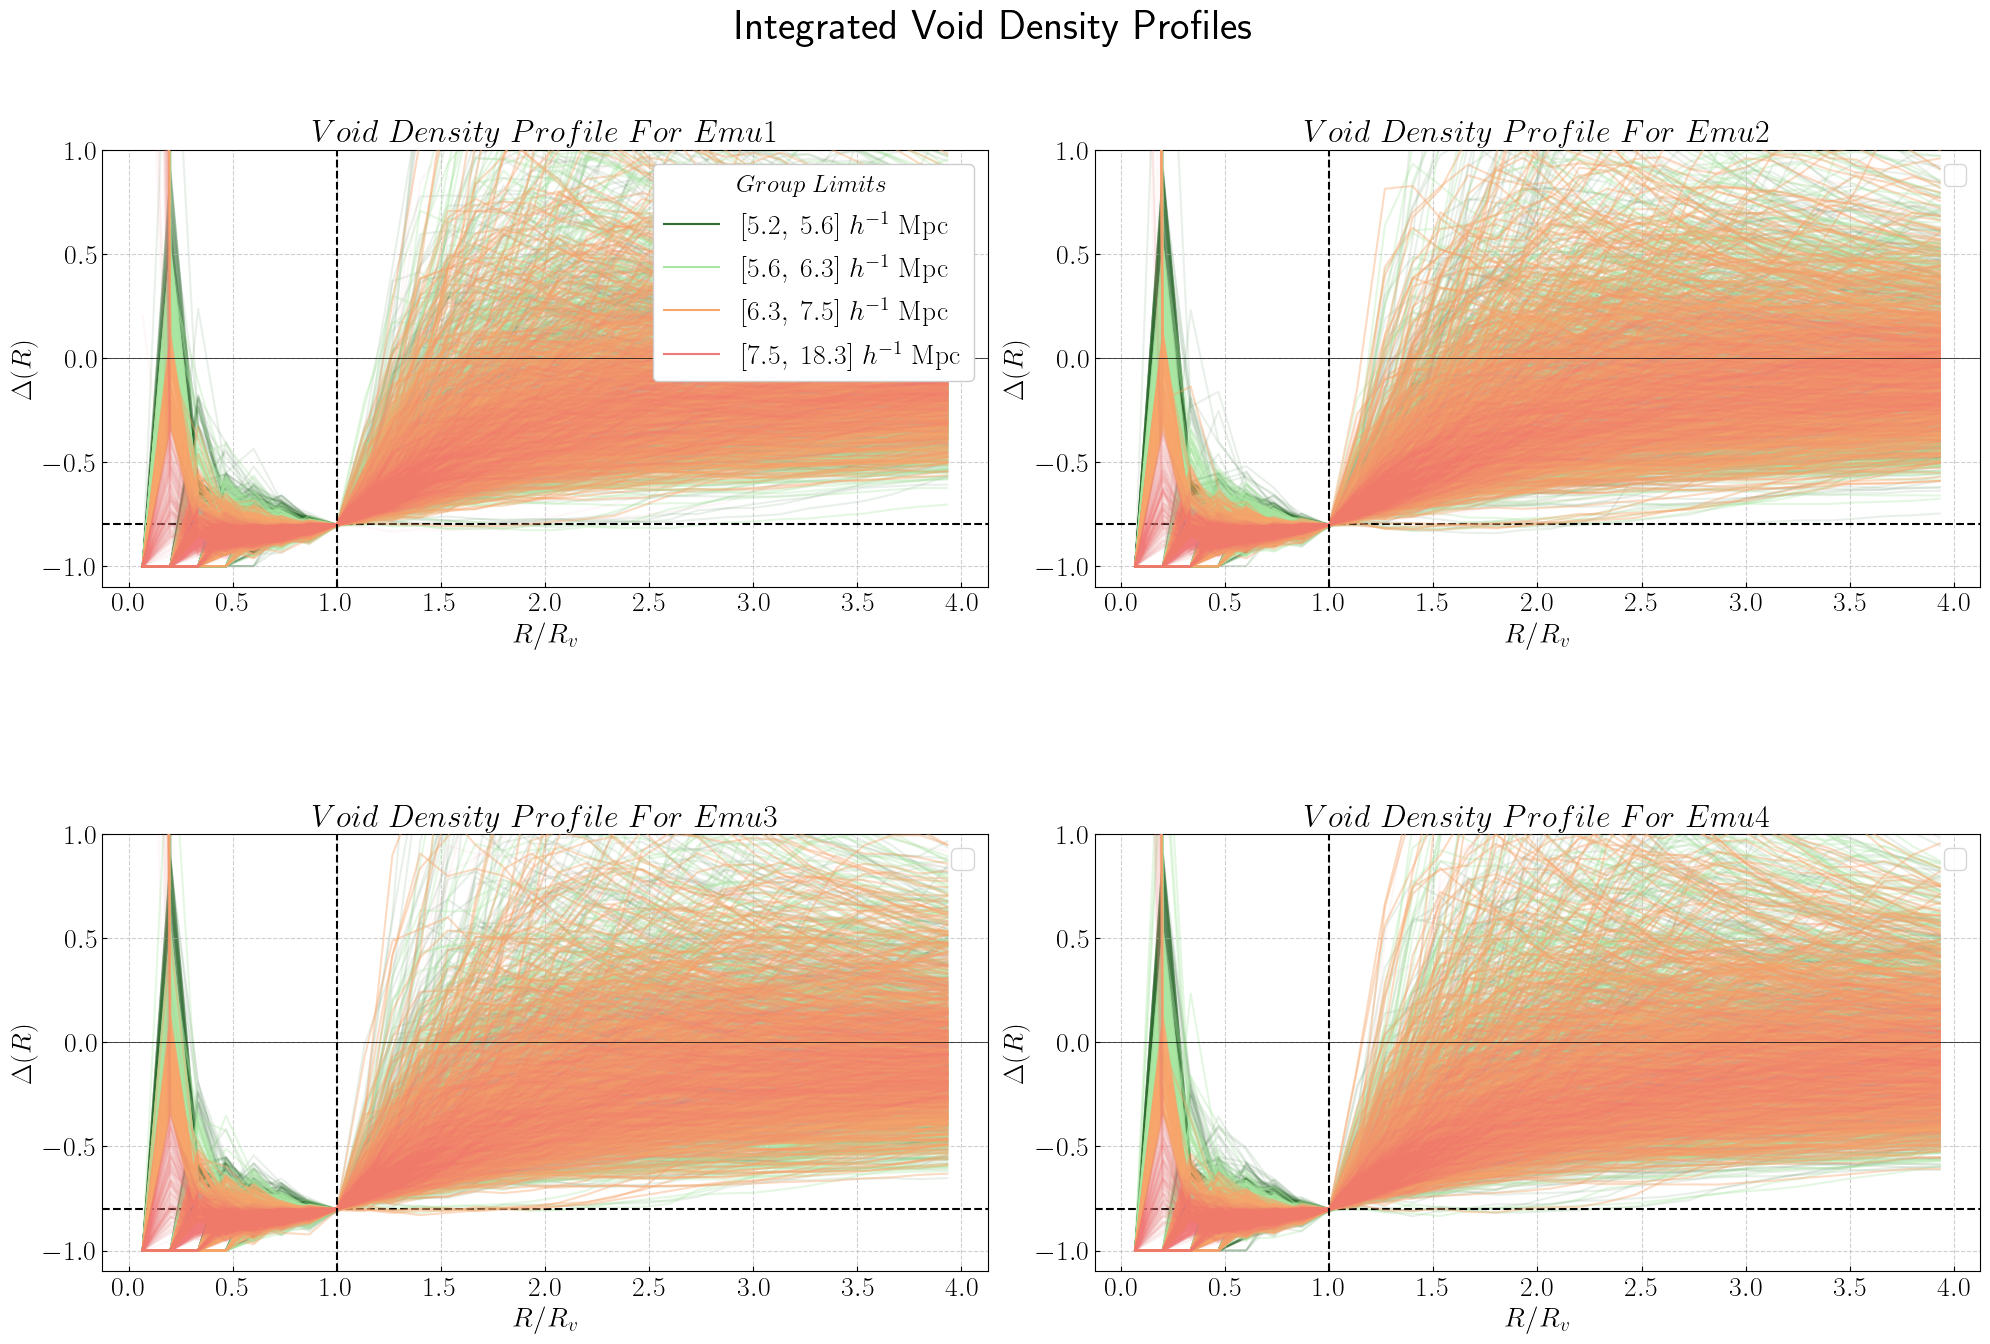

In [ ]:
colors = {1: "#2e6c2f", 2: "#a8e6a1", 3: "#f7a56a", 4: "#f07a7a"}
alphas = {1: 0.1, 2: 0.3, 3: 0.4, 4: 0.06}
order = [1, 2, 3, 4]
limits = [r_min] + [float(i) for i in group_limits]
limits = [round(float(i), 1) for i in limits]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), dpi=100)
fig.suptitle("Integrated Void Density Profiles", fontsize=30, y=0.95)
axes = axes.flatten()

dummy_handles = []
for group in sorted(delta_profiles_groups.keys()):
    line, = ax.plot([], [], color=colors[group], label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$')
    dummy_handles.append(line)


for i, ax in enumerate(axes[:n-1], start=1):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    delta_profiles_groups, radii_groups = np.load(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/{filename}_integrated_delta_profiles_population_spaced_groups.npy", allow_pickle=True)

    for group in delta_profiles_groups:
        for delta_profile in delta_profiles_groups[group]:
            ax.plot(scaled_bin_centers, delta_profile, marker='None', linestyle='-', color=colors[group], alpha=alphas[group], zorder = order[group-1])
            
    ax.set_ylim(-1.1, 1)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=20)
    ax.set_xlabel("$R/R_v$", fontsize=20)
    ax.set_ylabel("$\Delta(R)$", fontsize=20)
    ax.set_title(rf"$Void \ Density \ Profile \ For \ Emu{i}$", fontsize=23)
    ax.legend(fontsize=20)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axhline(y=0, color='k', ls='-', zorder=5, lw=0.5)
    ax.axvline(x=1, color='k', ls='--', zorder=5)
    ax.axhline(y=-0.8, color='k', ls='--')

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=dummy_handles, fontsize=20, framealpha = 1, loc='upper right', title="$Group \ Limits$", title_fontsize=18)


if len(axes) > n:
    axes[n].axis('off')
    axes[n-1].axis('off')

fig.subplots_adjust(wspace=0.15, hspace=0.25)
plt.tight_layout()

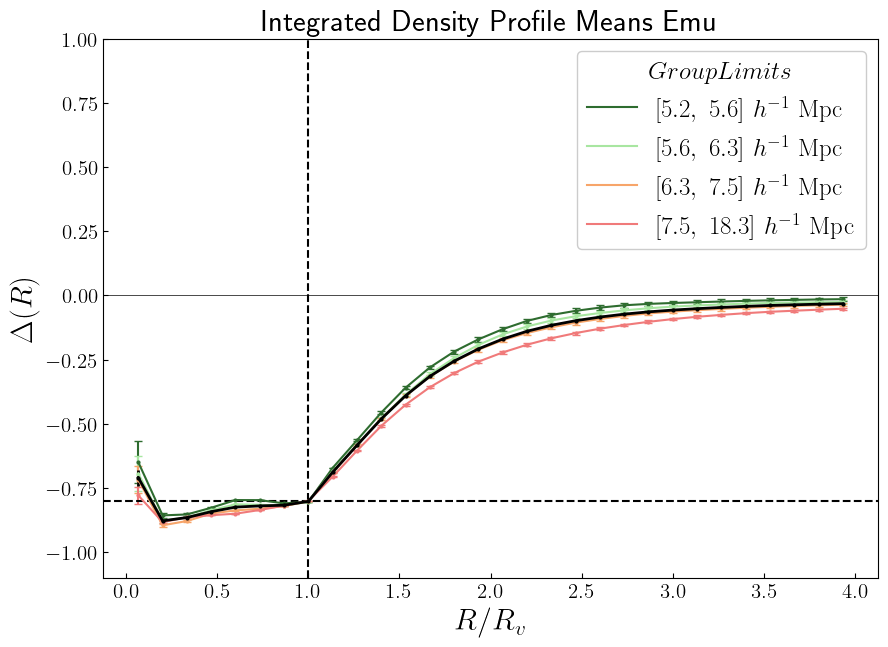

In [ ]:
#means
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
plt.ylim(-1.1, 1)

all_delta_profiles_groups, all_radii_groups = np.load("/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/all_integrated_delta_profiles_population_spaced_groups.npy", allow_pickle=True)

#mean for each bin
for group in all_delta_profiles_groups:
    group_delta_profiles = np.array(all_delta_profiles_groups[group])
    mean_profile = np.mean(group_delta_profiles, axis=0)
    std_profile = np.std(group_delta_profiles, axis=0) / np.sqrt(len(group_delta_profiles))

    ax.errorbar(scaled_bin_centers, mean_profile, yerr=std_profile, marker='o', linestyle='-', alpha = 1, color=colors[group], label=f'Group {group}', linewidth=1.5, markersize=2, capsize=3)

#overall mean
all_delta_profiles = []
for group in all_delta_profiles_groups:
    for delta_profile in all_delta_profiles_groups[group]:
        all_delta_profiles.append(delta_profile)
all_delta_profiles = np.array(all_delta_profiles)

#create mean
mean_delta_profile = np.mean(all_delta_profiles, axis=0)
std_delta_profile = np.std(all_delta_profiles, axis=0) / np.sqrt(len(all_delta_profiles))

#plot mean
ax.errorbar(scaled_bin_centers, mean_delta_profile, yerr=std_delta_profile, marker='o', linestyle='-', color='black', label= 'Mean', linewidth=2, markersize=2)
ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.axhline(y=0, color='k', ls='-', zorder=1, lw=0.5)
ax.axvline(x=1, color='k', ls='--')
ax.axhline(y=-0.8, color='k', ls='--')
plt.title('Integrated Density Profile Means Emu', fontsize=22)
plt.xlabel('$R/R_v$', fontsize=22)
plt.ylabel('$\Delta(R)$', fontsize=22)
ax.legend(handles=handles, fontsize=20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=dummy_handles, fontsize=18, framealpha=1, loc='upper right', title="$Group Limits$", title_fontsize=18)

In [ ]:
#Differential density profile
def apply_pbc(positions, box_size):
    return np.mod(positions, box_size)

def minimum_image(vecs, box_size):
    return np.where(np.abs(vecs) > box_size / 2, vecs - np.sign(vecs) * box_size, vecs)

# Setup
scaled_bins = np.linspace(0, 4, 31)
scaled_bin_centers = (scaled_bins[:-1] + scaled_bins[1:]) / 2

all_voids_sorted = []
sorted_voids_per_file = {}

for key, value in void_data_dict.items():
    sorted_void_arrays = sorted(value, key=lambda x: x[0])  
    sorted_voids_per_file[key] = np.array(sorted_void_arrays)
    all_voids_sorted.extend(sorted_void_arrays)

all_voids_sorted = np.array(sorted(all_voids_sorted, key=lambda x: x[0]))
all_radii = all_voids_sorted[:, 0]
group_limits = np.percentile(all_radii, [25, 50, 75, 100])
print("Group limits:", group_limits)

# Ergebniscontainer
all_delta_profiles_groups = {1: [], 2: [], 3: [], 4: []}
all_radii_groups = {1: [], 2: [], 3: [], 4: []}

# Hauptloop über alle Files
for i in range(1, n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    key = f"void_data_{filename}"
    voids = sorted_voids_per_file[key]

    delta_profiles_groups = {1: [], 2: [], 3: [], 4: []}
    radii_groups = {1: [], 2: [], 3: [], 4: []}

    # Lade Partikeldaten
    particles_data = np.loadtxt(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/emu_sims/{filename}.dat")
    positions = particles_data[:, :3]
    positions = apply_pbc(positions, a)  # <- falls nötig, nicht schädlich
    tree = cKDTree(positions, boxsize=a + 1e-13)

    for R_v_i, center_i in zip(voids[:, 0], voids[:, 1:4]):
        if R_v_i < r_min:
            continue

        # Gruppenzuordnung
        if r_min <= R_v_i < group_limits[0]:
            group = 1
        elif group_limits[0] <= R_v_i < group_limits[1]:
            group = 2
        elif group_limits[1] <= R_v_i < group_limits[2]:
            group = 3
        else:
            group = 4

        # Nachbarn im Umkreis von 7 * R_v
        indices = tree.query_ball_point(center_i, 4 * R_v_i)
        if len(indices) == 0:
            continue

        coords = positions[indices]
        vecs = coords - center_i
        vecs = minimum_image(vecs, a)  # ← PBC hier!
        dists = np.linalg.norm(vecs, axis=1)

        shell_edges = np.linspace(0, 4 * R_v_i, 31)
        density_profile = []

        for j in range(len(shell_edges) - 1):
            in_shell = (dists >= shell_edges[j]) & (dists < shell_edges[j + 1])
            if np.any(in_shell):
                n_particles = np.sum(in_shell)
                volume = (4/3) * np.pi * (shell_edges[j+1]**3 - shell_edges[j]**3)
                density = n_particles / volume
                density_profile.append(density)
            else:
                density_profile.append(0)

        density_profile = np.array(density_profile)
        delta_profile = density_profile / n_m - 1

        # Speichern in Gruppencontainern
        delta_profiles_groups[group].append(delta_profile)
        radii_groups[group].append(R_v_i)

    # Speichern pro File
    np.save(
        f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/{filename}_differential_delta_profiles_equipopulated_groups.npy",
        (delta_profiles_groups, radii_groups))

    # Zu globalen Containern hinzufügen
    for group in delta_profiles_groups:
        all_delta_profiles_groups[group].extend(delta_profiles_groups[group])
        all_radii_groups[group].extend(radii_groups[group])

# Alles zusammen speichern
np.save("/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/all_differential_delta_profiles_equipopulated_groups.npy", (all_delta_profiles_groups, all_radii_groups))

Group limits: [ 5.62761  6.25165  7.47737 18.30893]


/var/folders/ss/qz81s18561g4v9nxv6k7wq_w0000gn/T/ipykernel_95954/1031224658.py:24: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



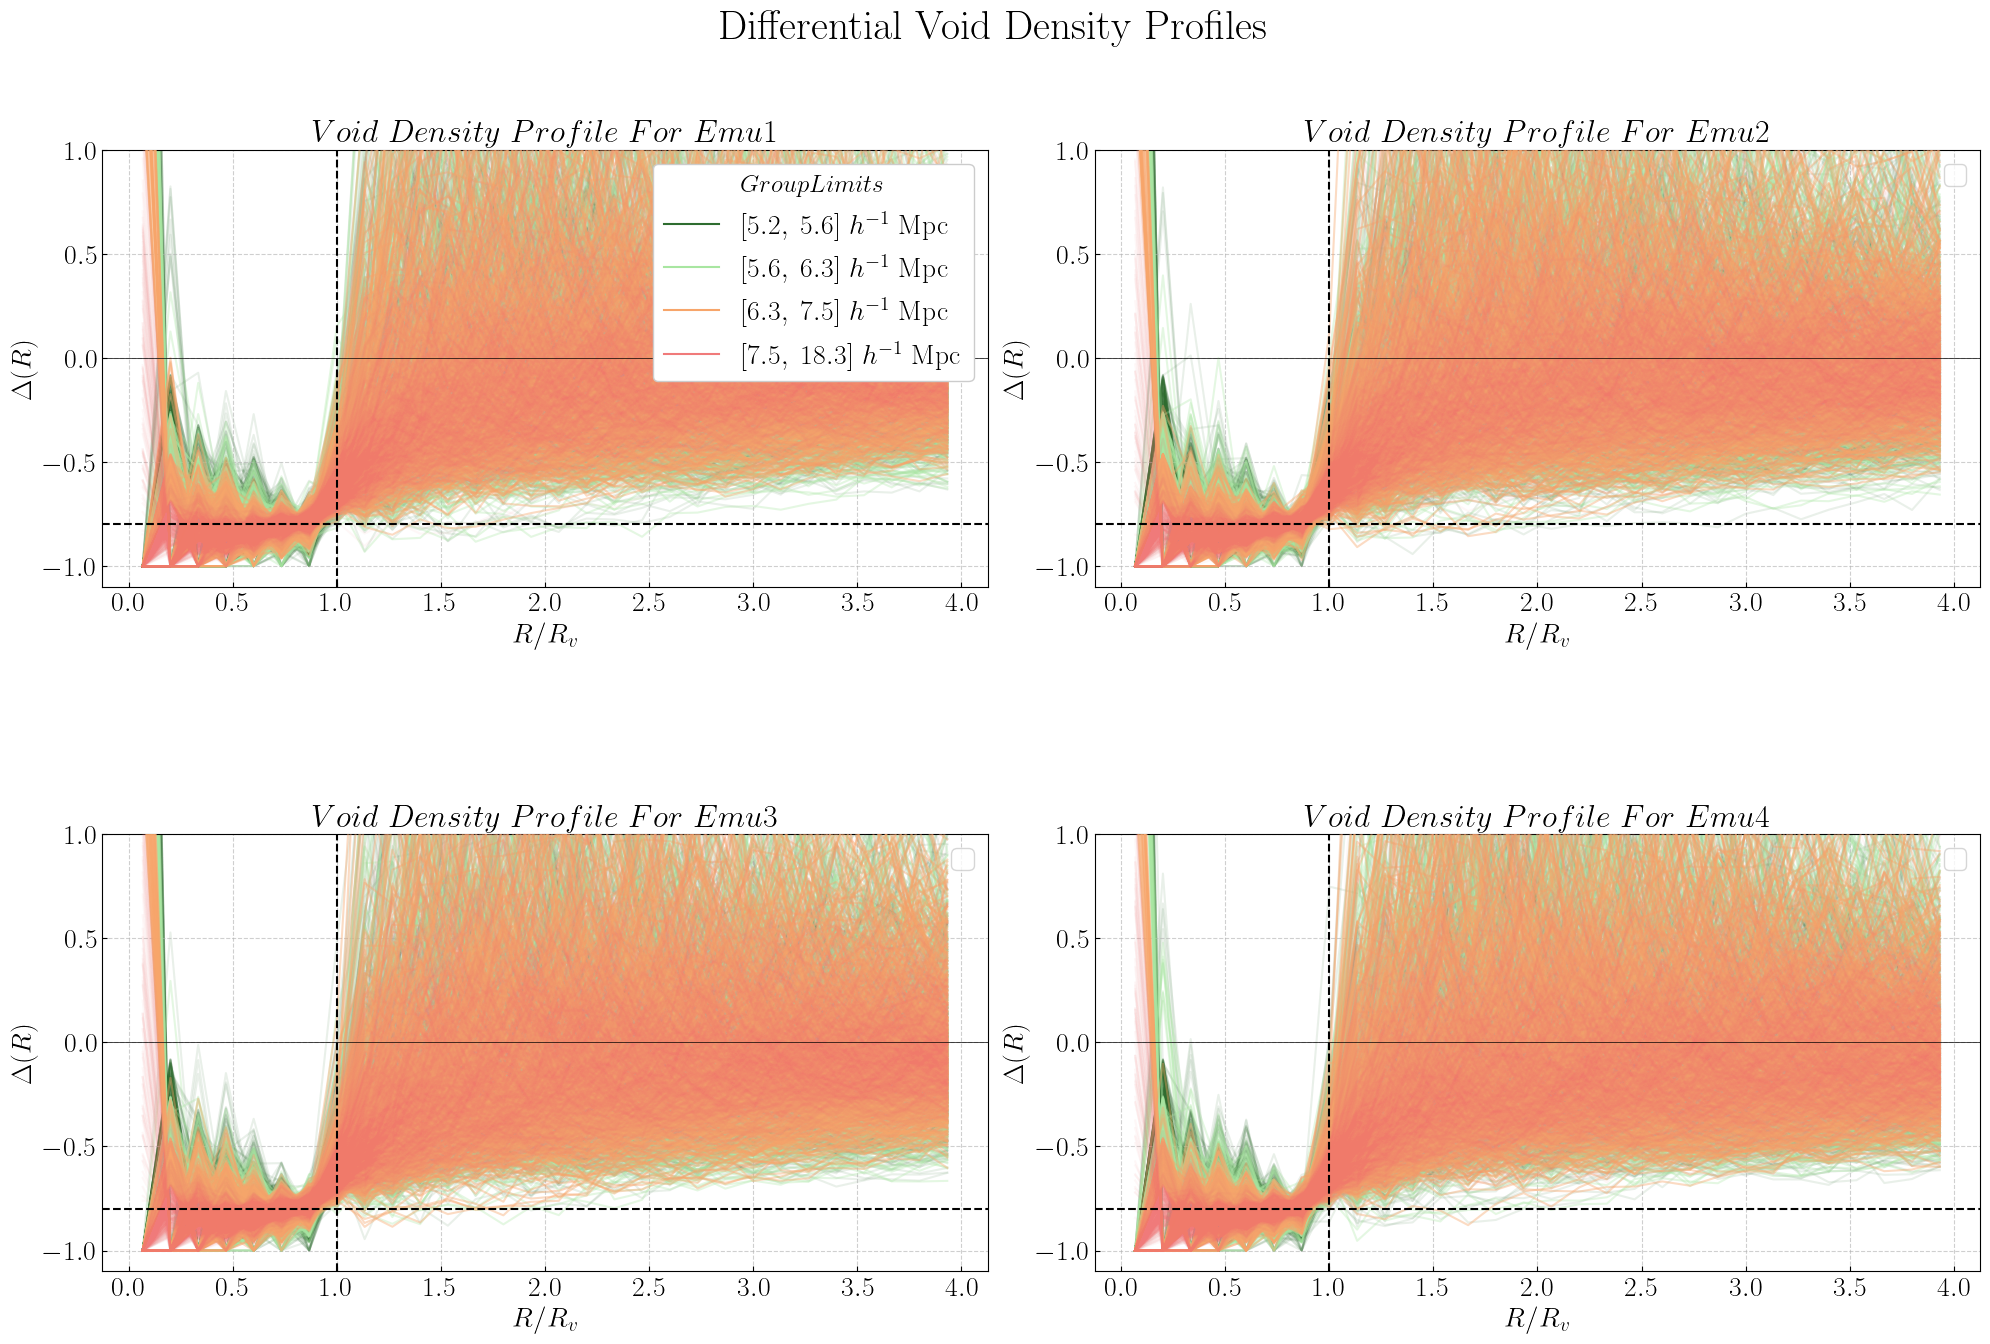

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), dpi=100)
fig.suptitle("$ \mathrm{Differential \ Void \ Density \ Profiles} $", fontsize=30, y=0.95)
axes = axes.flatten()

dummy_handles = []
for group in sorted(delta_profiles_groups.keys()):
    line, = ax.plot([], [], color=colors[group], label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$')
    dummy_handles.append(line)


for i, ax in enumerate(axes[:n-1], start=1):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    delta_profiles_groups, radii_groups = np.load(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/{filename}_differential_delta_profiles_equipopulated_groups.npy", allow_pickle=True)

    for group in delta_profiles_groups:
        for delta_profile in delta_profiles_groups[group]:
            ax.plot(scaled_bin_centers, delta_profile, marker='None', linestyle='-', color=colors[group], alpha=alphas[group], zorder = order[group-1])
            
    ax.set_ylim(-1.1, 1)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=20)
    ax.set_xlabel("$R/R_v$", fontsize=20)
    ax.set_ylabel("$\Delta(R)$", fontsize=20)
    ax.set_title(rf"$Void \ Density \ Profile \ For \ Emu{i}$", fontsize=23)
    ax.legend(fontsize=20)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axhline(y=0, color='k', ls='-', zorder=5, lw=0.5)
    ax.axvline(x=1, color='k', ls='--', zorder=5)
    ax.axhline(y=-0.8, color='k', ls='--', zorder = 5)

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=dummy_handles, fontsize=20, framealpha = 1, loc='upper right', title="$Group Limits$", title_fontsize=18)


if len(axes) > n:
    axes[n].axis('off')
    axes[n-1].axis('off')

fig.subplots_adjust(wspace=0.15, hspace=0.25)
plt.tight_layout()


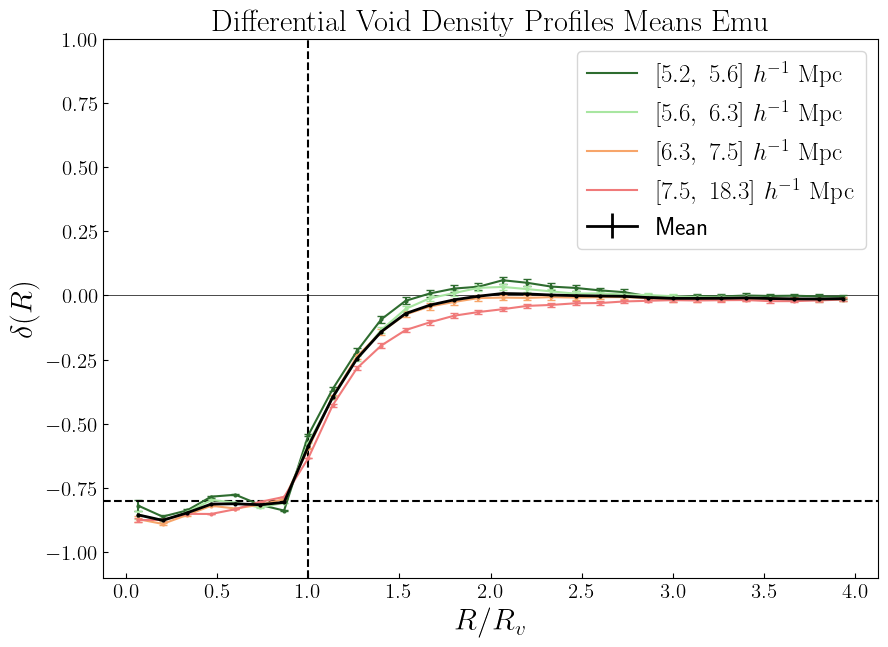

In [ ]:
#means
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
plt.ylim(-1.1, 1)

dummy_handles = []
for group in sorted(delta_profiles_groups.keys()):
    line, = ax.plot([], [], color=colors[group], label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$')
    dummy_handles.append(line)

all_delta_profiles_groups, all_radii_groups = np.load("/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/all_differential_delta_profiles_equipopulated_groups.npy", allow_pickle=True)

#mean for each bin
for group in all_delta_profiles_groups:
    group_delta_profiles = np.array(all_delta_profiles_groups[group])
    mean_profile = np.mean(group_delta_profiles, axis=0)
    std_profile = np.std(group_delta_profiles, axis=0) / np.sqrt(len(group_delta_profiles))

    ax.errorbar(scaled_bin_centers, mean_profile, yerr=std_profile, marker='o', linestyle='-', alpha = 1, color=colors[group], linewidth=1.5, markersize=2, capsize=3)

#overall mean
all_delta_profiles = []
for group in all_delta_profiles_groups:
    for delta_profile in all_delta_profiles_groups[group]:
        all_delta_profiles.append(delta_profile)
all_delta_profiles = np.array(all_delta_profiles)

#create mean
mean_delta_profile = np.mean(all_delta_profiles, axis=0)
std_delta_profile = np.std(all_delta_profiles, axis=0) / np.sqrt(len(all_delta_profiles))

#plot mean
ax.errorbar(scaled_bin_centers, mean_delta_profile, yerr=std_delta_profile, marker='o', linestyle='-', color='black', label= 'Mean', linewidth=2, markersize=2)
ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.axhline(y=0, color='k', ls='-', zorder=1, lw=0.5)
ax.axvline(x=1, color='k', ls='--')
ax.axhline(y=-0.8, color='k', ls='--')
plt.title('$ \mathrm{Differential \ Void \ Density \ Profiles \ Means \ Emu} $', fontsize=22)
plt.xlabel('$R/R_v$', fontsize=22)
plt.ylabel('$\delta(R)$', fontsize=22)


handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=dummy_handles, fontsize=20, framealpha = 1)
ax.legend(fontsize=18)

In [ ]:
# Ergebniscontainer
all_velocity_profiles_groups = {1: [], 2: [], 3: [], 4: []}
all_radii_groups = {1: [], 2: [], 3: [], 4: []}
scaled_bins = np.linspace(0, 10, 31)
scaled_bin_centers = (scaled_bins[:-1] + scaled_bins[1:]) / 2
for i in range(1, n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    key = f"void_data_{filename}"
    voids = sorted_voids_per_file[key]

    velocity_profiles_groups = {1: [], 2: [], 3: [], 4: []}
    radii_groups = {1: [], 2: [], 3: [], 4: []}

    particles_data = np.loadtxt(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/emu_sims/{filename}.dat")
    positions = particles_data[:, :3]
    velocities = particles_data[:, 3:6]
    positions = apply_pbc(positions, a)
    tree = cKDTree(positions, boxsize=a + 1e-13)

    for R_v_i, center_i in zip(voids[:, 0], voids[:, 1:4]):
        if R_v_i < r_min:
            continue

        if r_min <= R_v_i < group_limits[0]:
            group = 1
        elif group_limits[0] <= R_v_i < group_limits[1]:
            group = 2
        elif group_limits[1] <= R_v_i < group_limits[2]:
            group = 3
        else:
            group = 4

        indices = tree.query_ball_point(center_i, 10 * R_v_i)
        if len(indices) == 0:
            continue

        coords = positions[indices]
        vels = velocities[indices]
        vecs = coords - center_i
        vecs = minimum_image(vecs, a)  #PBC here!
        dists = np.linalg.norm(vecs, axis=1)
    
        v_rad = np.zeros_like(dists)
        valid = dists > 0
        v_rad[valid] = np.sum(vels[valid] * vecs[valid], axis=1) / dists[valid]

        #mean for each shell
        shell_edges = np.linspace(0, 10 * R_v_i, 31)
        shell_v_rad_mean = []

        for j in range(len(shell_edges) - 1):
            in_shell = (dists >= shell_edges[j]) & (dists < shell_edges[j + 1])
            if np.any(in_shell):
                mean_v = np.mean(v_rad[in_shell])
            else:
                mean_v = np.nan

            shell_v_rad_mean.append(mean_v)

        shell_v_rad_mean = np.array(shell_v_rad_mean)
        velocity_profiles_groups[group].append(shell_v_rad_mean)
        radii_groups[group].append(R_v_i)

    #save each file
    np.save(
        f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/{filename}_velocity_profiles_equipopulated_groups.npy",
        (velocity_profiles_groups, radii_groups))

    for group in velocity_profiles_groups:
        all_velocity_profiles_groups[group].extend(velocity_profiles_groups[group])
        all_radii_groups[group].extend(radii_groups[group])
#save for all files
np.save("/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/all_velocity_profiles_equipopulated_groups.npy", (all_velocity_profiles_groups, all_radii_groups))

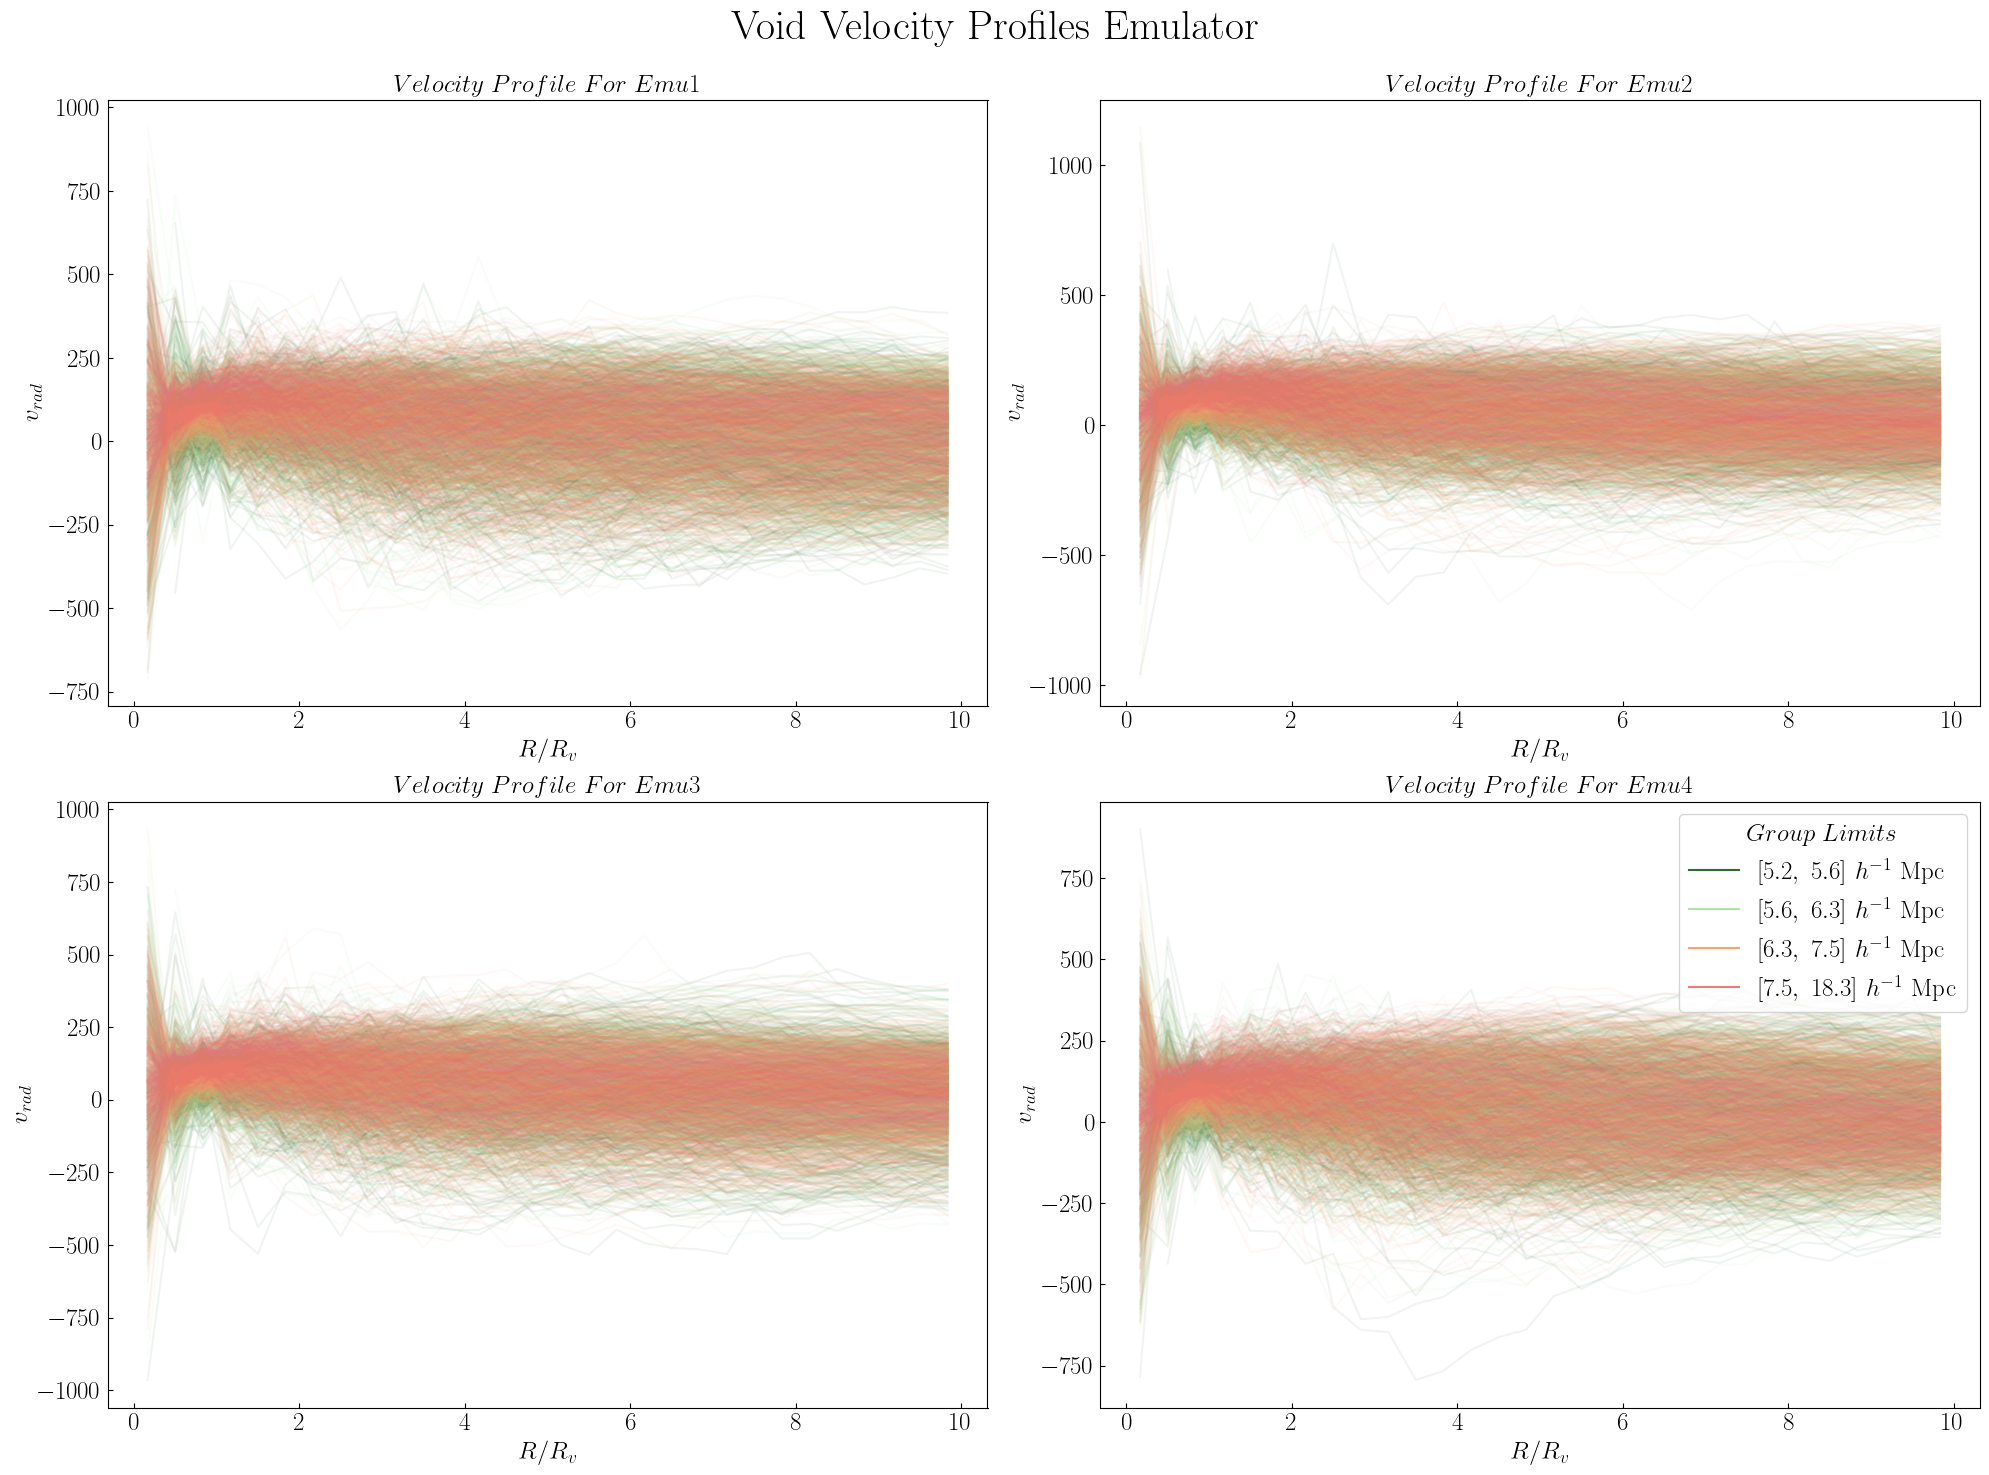

In [ ]:
alphas = {1: 0.07, 2: 0.07, 3: 0.07, 4: 0.05}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), dpi=100)
axs = axs.flatten()

for i in range(1,n):
    filename = f"L400-N128_set1_emu_run06{i:02}"
    velocity_profiles_groups, radii_groups = np.load(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/{filename}_velocity_profiles_equipopulated_groups.npy", allow_pickle=True)
    ax = axs[i-1]
    for group in velocity_profiles_groups:
        for velocity_profile in velocity_profiles_groups[group]:
            ax.plot(scaled_bin_centers, velocity_profile, 
                    marker='None', linestyle='-', 
                    color=colors[group], alpha=alphas[group])
            
    ax.set_title(f"$Velocity \ Profile \ For \ Emu{i}$", fontsize=18)
    ax.set_xlabel('$R/R_v$', fontsize=18)
    ax.set_ylabel('$v_{rad}$', fontsize=18)
    ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=18)
    ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=18)

dummy_handles = []
for group in sorted(velocity_profiles_groups.keys()):
    line, = ax.plot([], [], color=colors[group], label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$')
    dummy_handles.append(line)

ax.legend(handles=dummy_handles, fontsize=18, loc = 'upper right', title="$Group \ Limits$", title_fontsize=18)


fig.suptitle("$ \mathrm{Void \ Velocity \ Profiles \ Emulator} $", fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

/var/folders/ss/qz81s18561g4v9nxv6k7wq_w0000gn/T/ipykernel_95954/638842442.py:42: MatplotlibDeprecationWarning:

An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.



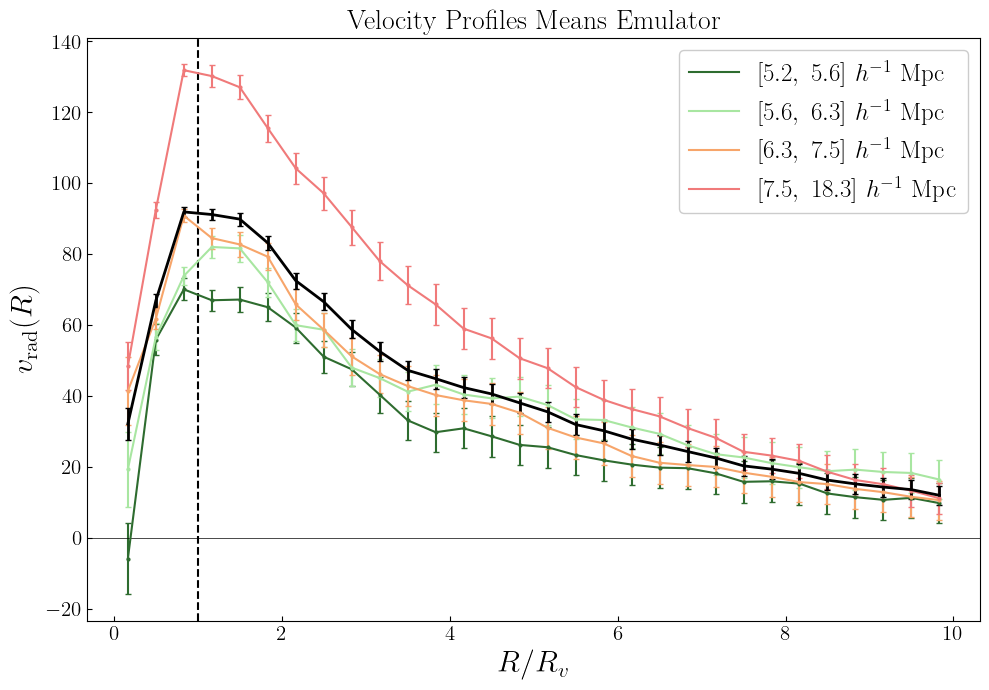

In [ ]:
#means
all_velocity_profiles_groups, all_radii_groups = np.load("/Users/CHermann/Desktop/MPE/Bachelor_thesis/Emu_results/Numpy_files/all_velocity_profiles_equipopulated_groups.npy", allow_pickle=True)
fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

mean_profiles = {}
for group in all_velocity_profiles_groups:
    all_profiles = []
    for velocity_profile in velocity_profiles_groups[group]:
        all_profiles.append(velocity_profile)
    if all_profiles:
        all_profiles = np.array(all_profiles)  
        mean_profiles[group] = np.nanmean(all_profiles, axis=0)  # ignore NaNs
        std_profile = np.nanstd(all_profiles, axis=0) / np.sqrt(len(all_profiles))

        #plot mean of each group
        ax.errorbar(scaled_bin_centers, mean_profiles[group], yerr=std_profile, marker='o', color=colors[group], linewidth=1.5, label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$', capsize=2, markersize=2)

    group_velocity_profiles = np.array(all_velocity_profiles_groups[group])
    mean_profile = np.nanmean(group_velocity_profiles, axis=0)
    std_profile = np.nanstd(group_velocity_profiles, axis=0) / np.sqrt(np.sum(~np.isnan(group_velocity_profiles), axis=0))

all_void_profiles = []
for group in all_velocity_profiles_groups:
    for velocity_profile in velocity_profiles_groups[group]:
        all_void_profiles.append(velocity_profile)

if all_void_profiles:
    all_void_profiles = np.array(all_void_profiles)
    global_mean_profile = np.nanmean(all_void_profiles, axis=0)  # ignore NaNs
    std_profile = np.nanstd(all_void_profiles, axis=0) / np.sqrt(len(all_void_profiles))
    ax.errorbar(scaled_bin_centers, global_mean_profile, yerr=std_profile, color='black', linewidth=2, linestyle='-', label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$', capsize =2)

ax.axhline(y=0, color='k', ls='-', lw=0.5)
ax.axvline(x=1, color='k', ls='--')
ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)

plt.title('$\mathrm{Velocity \ Profiles \ Means \ Emulator}$', fontsize=20)
plt.xlabel(r'$R/R_v$', fontsize=22)
plt.ylabel(r'$v_{\mathrm{rad}}(R)$', fontsize=22)

ax.legend(handles=dummy_handles + [ax.lines[-1]], fontsize=18, framealpha=1)
plt.tight_layout()